In [24]:
#from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ, GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [25]:
import pandas as pd
import numpy as np
from pyproj import Proj
from scipy.spatial import cKDTree
from netCDF4 import Dataset
from datetime import datetime, timedelta

class RealWind:
    def __init__(self, start_date="2019-10-01", num_days=9):
        """
        Precompute and store wind data in a pandas DataFrame for fast lookup.
        The table includes time, northing, easting, U (east wind), and V (north wind).
        """
        self.proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
        self.wind_table = []  # List to accumulate wind data

        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        layer_range = (56, 68)  # Height range for averaging wind speeds
        bounding_box = (149, -35, 157, -26)

        for day_offset in range(num_days):
            current_date = start_date + timedelta(days=day_offset)
            date_str = current_date.strftime('%Y%m%d')
            file_path = rf"C:\\Users\\Nur Izfarwiza\\Documents\\Dissertation\\Wind\\MERRA2_400.tavg3_3d_asm_Nv.{date_str}.nc4"

            try:
                dataset = Dataset(file_path, 'r')
                lats = dataset.variables['lat'][:]
                lons = dataset.variables['lon'][:]
                
                # Apply the bounding box filter
                lat_indices = np.where((lats >= bounding_box[1]) & (lats <= bounding_box[3]))[0]
                lon_indices = np.where((lons >= bounding_box[0]) & (lons <= bounding_box[2]))[0]

                lats = lats[lat_indices]
                lons = lons[lon_indices]

                # Load and filter wind data within the bounding box
                eastward_wind = dataset.variables['U'][:, :, lat_indices, :][:, :, :, lon_indices]
                northward_wind = dataset.variables['V'][:, :, lat_indices, :][:, :, :, lon_indices]

                # Average over the specified vertical layers
                layer_range_slice = slice(layer_range[0], layer_range[1])
                eastward_wind_avg = np.mean(eastward_wind[:, layer_range_slice, :, :], axis=1)
                northward_wind_avg = np.mean(northward_wind[:, layer_range_slice, :, :], axis=1)

                # Read and convert the time variable
                print("NASA Time Units:", dataset.variables['time'].units)
                time_var = np.array(dataset.variables['time'][:], dtype=np.float64)
                base_time_str = dataset.variables['time'].units.split(" since ")[1]
                base_time = datetime.strptime(base_time_str, "%Y-%m-%d %H:%M:%S")

                for t_idx, t_val in enumerate(time_var):
                    if not np.isfinite(t_val):
                        continue  # Skip invalid time values
                    timestamp = base_time + timedelta(minutes=int(t_val))

                    # Vectorized coordinate transformation
                    lon_grid, lat_grid = np.meshgrid(lons, lats)
                    easting, northing = self.proj(lon_grid, lat_grid)

                    # Flatten arrays to create a table of points
                    easting = easting.flatten()
                    northing = northing.flatten()
                    u_wind = eastward_wind_avg[t_idx].flatten()
                    v_wind = northward_wind_avg[t_idx].flatten()

                    # Filter out invalid projections
                    valid_mask = np.isfinite(easting) & np.isfinite(northing) & np.isfinite(u_wind) & np.isfinite(v_wind)

                    # Append valid data to the wind table
                    self.wind_table.extend(
                        zip([timestamp] * np.sum(valid_mask),
                            northing[valid_mask],
                            easting[valid_mask],
                            u_wind[valid_mask],
                            v_wind[valid_mask])
                    )

                dataset.close()

            except FileNotFoundError:
                print(f"File for {date_str} not found.")
            except Exception as e:
                print(f"Error loading {date_str}: {e}")

        # Convert to pandas DataFrame for fast lookups
        self.wind_table = pd.DataFrame(self.wind_table, columns=["Timestamp", "Northing", "Easting", "East Wind", "North Wind"])

        # Clean data: Drop NaN or Inf values
        self.wind_table = self.wind_table.replace([np.inf, -np.inf], np.nan)
        self.wind_table = self.wind_table.dropna()

        # Sort by timestamp for faster temporal queries
        self.wind_table = self.wind_table.sort_values(by="Timestamp").reset_index(drop=True)

        # Build a spatial KD-Tree for efficient spatial querying
        self.wind_tree = cKDTree(self.wind_table[["Easting", "Northing"]].values)

        print(f"Wind data precomputed for {len(self.wind_table)} points across {num_days} days.")
    
    def getwind(self, coords):
        """
        Get the nearest-neighbor wind speed for particles at given positions and times.

        Parameters:
        - coords: A tensor of shape (num_particles, num_observations, 3)
                  where each entry is [time, easting, northing].

        Returns:
        - wind_data: A tensor of shape (num_particles, num_observations, 2)
                     where each entry is [east_wind_speed, north_wind_speed].
        """
        num_particles, num_observations, _ = coords.shape
        wind_data = np.full((num_particles, num_observations, 2), np.nan)  # Initialize with NaN

        # Convert timestamps to datetime
        timestamps = np.array([datetime(2019, 10, 1) + timedelta(seconds=int(t)) 
                               for t in coords[:,:,0].flatten()])
        # print("Shape of coords received in getwind:", coords.shape)
        # print("Data type of received t:", coords[...,0].dtype)  # Check dtype in `getwind()`
        # print("Sample values of received t:", coords[...,0][:5])  # Print first 5 values
        for i in range(num_particles):
            for j in range(num_observations):
                easting, northing = coords[i, j, 1], coords[i, j, 2]
                timestamp = timestamps[i * num_observations + j]

                # Find the closest timestamp index
                closest_time_idx = (np.abs(self.wind_table["Timestamp"] - timestamp)).idxmin()

                # Find the nearest spatial entry using KD-Tree (k=1 for nearest neighbor)
                dist, closest_idx = self.wind_tree.query([easting, northing], k=1)

                # Retrieve precomputed wind speeds directly
                wind_data[i, j] = self.wind_table.loc[closest_idx, ["East Wind", "North Wind"]]

        return wind_data


In [26]:
mInfer.computeModelRegressors(Nparticles=20) 

Initialising particles...
Diffusing particles...
Data type of received t: float64
Sample values of received t: [[ 0.47163116 13.5351381  20.68634741 ... 48.62510051 50.18086934
  61.63084103]
 [ 3.45156752 17.34430849 23.91292472 ... 45.59224772 54.60853505
  61.3330988 ]
 [ 7.90800103 12.38205701 26.38090645 ... 43.29880421 56.37011318
  66.25510812]
 [ 5.82720981 13.34884947 23.09847865 ... 47.22968257 54.65874781
  65.75567804]
 [ 1.58850607 11.56665649 25.63251428 ... 41.98286263 51.74620983
  63.59331753]]
Data type of received t: float64
Sample values of received t: [[-0.22836884 12.8351381  19.98634741 ... 47.92510051 49.48086934
  60.93084103]
 [ 2.75156752 16.64430849 23.21292472 ... 44.89224772 53.90853505
  60.6330988 ]
 [ 7.20800103 11.68205701 25.68090645 ... 42.59880421 55.67011318
  65.55510812]
 [ 5.12720981 12.64884947 22.39847865 ... 46.52968257 53.95874781
  65.05567804]
 [ 0.88850607 10.86665649 24.93251428 ... 41.28286263 51.04620983
  62.89331753]]
Data type of re

array([[ 1.26460927e-01, -3.48043610e-01, -7.03555016e-01, ...,
        -3.08888199e-01, -2.22046254e-01, -1.08814553e-01],
       [-9.99492673e-02, -6.52386146e-01,  4.01818498e-01, ...,
        -6.51772696e-01,  1.62979261e+00,  1.15326480e+00],
       [ 4.59258321e-02, -7.76045594e-02,  3.25669538e-02, ...,
        -7.27386711e-02, -1.79213722e-02, -2.29234904e-04],
       ...,
       [-1.16176459e-01, -1.43685999e-01,  3.45861673e-02, ...,
        -5.68543839e-02, -9.13410942e-02,  3.02123155e-02],
       [ 5.09426416e-02,  1.12759422e-02,  1.71887291e-02, ...,
        -2.82382440e-02, -3.40338655e-03,  3.17363707e-02],
       [-3.83094085e-02, -2.20121734e-03,  2.40280789e-02, ...,
         1.66553498e-02,  1.53455976e-02, -5.61653500e-03]])

In [27]:
windmodel = RealWind(start_date="2019-10-01", num_days=2)  # Load real wind data


NASA Time Units: minutes since 2019-10-01 01:30:00


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_45552\3125306111.py:49: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_45552\3125306111.py:49: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)


NASA Time Units: minutes since 2019-10-02 01:30:00
Wind data precomputed for 3952 points across 2 days.


Generate some synthetic concentration data.
We have a source of pollution at [10, 20] at time -4.

In [28]:
from scipy.stats import norm

def getrealconc(t,x,y,D):
    """For a sythentic dataset, provides the real concentration that will result from the simulated sources
    """
    blobcentre = np.array([t+10,t+20]) #1m/s
    blobsize = np.sqrt(2*2*D*(t+4))
    if blobsize<1: blobsize=1
    d = np.linalg.norm(np.array([x,y])-blobcentre)
    #v = d
    v = 1000*norm(0,blobsize).pdf(d)*norm(10,1).cdf(t)/blobsize #normalised.
    
    return [t,t+10,x,y],v

In [29]:
X = []
Y = []
D = 2
for x in np.linspace(10,90,7):#7):
    for y in np.linspace(10,90,7):#7):
        for t in np.linspace(0,60,7):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

Plot the concentration over time:

C:\Users\Nur Izfarwiza\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


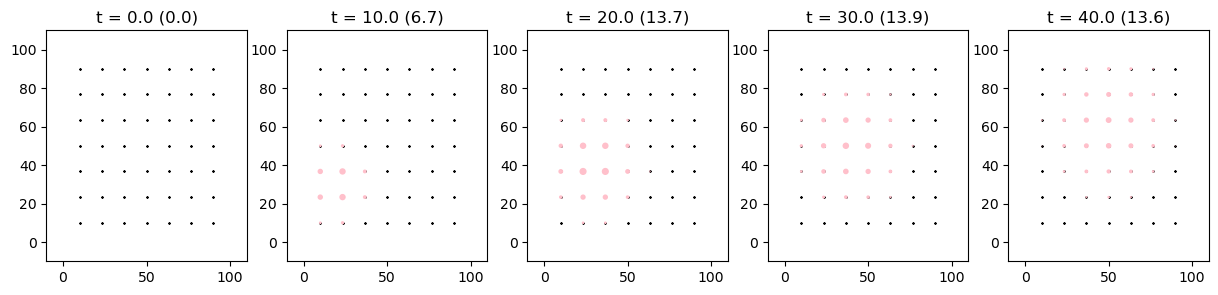

In [30]:
from matplotlib import pyplot as plt
plt.figure(figsize=[15,3])
for i,t in enumerate(np.arange(0,50,10)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')
    plt.title("t = %0.1f (%0.1f)" % (t,np.sum(Y[keep])))
    

In [31]:
from advectionGPdatasets import proposeboundary
boundary = proposeboundary(X) #for our given observation locations pick a boundary that fits them all
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10
#boundary = ([-7.0, -10, -10], [77.0, 100, 100])
print(boundary)

([-7.0, -10, -10], [77.0, 98.0, 98.0])


In [32]:
np.random.seed(42) #random seed fixed at start
#set up our model...
N_feat = 1500 #Number of features used to infer the source
k = EQ(10, 1) #our choice of kernel [EQ kernel, using fourier features]
#k = GaussianBases(25, 1) #<--- This kernel doesn't place features randomly, but on a grid!
res = [120,30,30] #120 time steps...

noiseSD = 0.001 #this is how noisy the measurements are.

sensors = FixedSensorModel(X,3) #this is how our data is observed.

# windmodel=WindSimple(1,1) #wind is the same everywhere it heads north east at 1.4m/s
windmodel = RealWind(start_date="2019-10-01", num_days=2)  # Load real wind data

k_0 = 0.5 #diffusion cooef? [doesn't match the simulation!!]

#Initiate new model for inference
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0)

mInfer.computeModelRegressors(Nparticles=20) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix

#simple way
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

#if we want lots of samples from the posterior do this...
Nsamps = 20
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)
print("Actual number of features: %d" % k.N_feat)

NASA Time Units: minutes since 2019-10-01 01:30:00


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_45552\3125306111.py:49: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_45552\3125306111.py:49: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)


NASA Time Units: minutes since 2019-10-02 01:30:00
Wind data precomputed for 3952 points across 2 days.
Initialising particles...
Diffusing particles...
Data type of received t: float64
Sample values of received t: [[ 9.32443978 19.37704615 26.61901576 ... 43.98836615 59.65388704
  65.23974203]
 [ 9.47306899 19.12254561 24.34048868 ... 47.50388927 51.49261897
  61.34874846]
 [ 3.69017732 19.46075618 28.19427854 ... 40.73175099 58.19438082
  60.25982294]
 [ 1.35516874 12.44715597 29.05582138 ... 40.89478383 52.75922553
  61.52805809]
 [ 5.18399627 11.31565307 21.19759966 ... 46.51973714 53.50702327
  66.26853621]]
Data type of received t: float64
Sample values of received t: [[ 8.62443978 18.67704615 25.91901576 ... 43.28836615 58.95388704
  64.53974203]
 [ 8.77306899 18.42254561 23.64048868 ... 46.80388927 50.79261897
  60.64874846]
 [ 2.99017732 18.76075618 27.49427854 ... 40.03175099 57.49438082
  59.55982294]
 [ 0.65516874 11.74715597 28.35582138 ... 40.19478383 52.05922553
  60.828

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_45552\2387169945.py:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)


cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...


In [33]:
print(type(mInfer.windmodel))  # This should print <class '__main__.RealWind'>
wind_data = self.windmodelgetwind(coords)

# Print shape before passing to getwind
print("Shape of coords being passed to getwind:", particles[:,:,1:].shape)  
print("Expected shape: (num_particles, num_observations, 3) [time, easting, northing]")
mInfer.computeModelRegressors(Nparticles=20) 

# Call windmodel.getwind
wind = self.windmodel.getwind(particles[:,:,1:])*dt




<class '__main__.RealWind'>


NameError: name 'self' is not defined

In [ ]:
sourcemean.shape

In [34]:
mInfer.getGridCoord([10,0,0])[0]

24

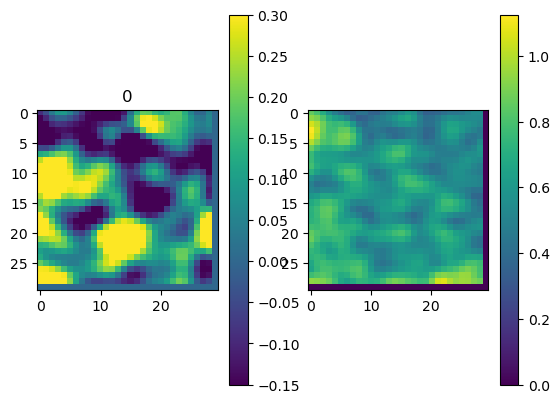

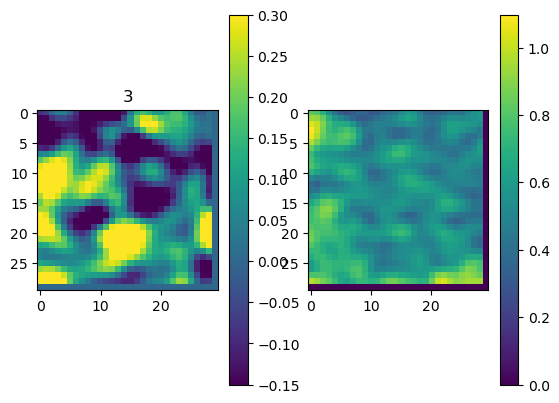

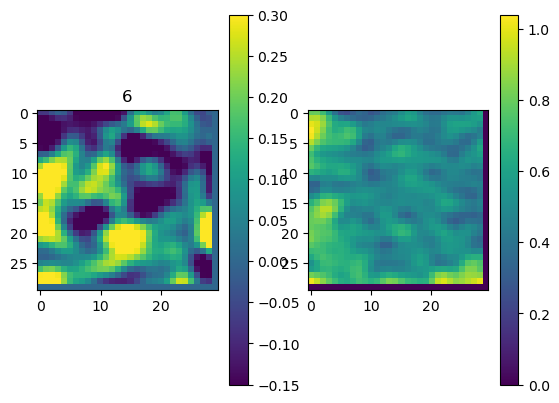

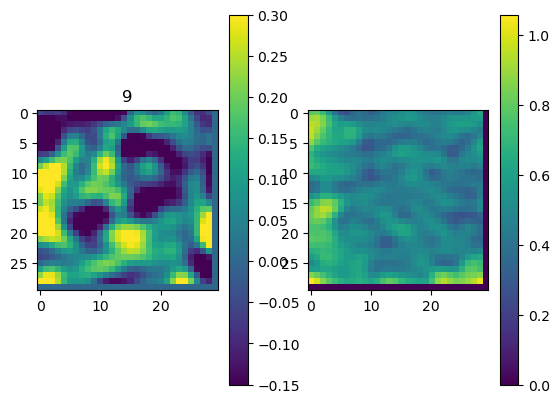

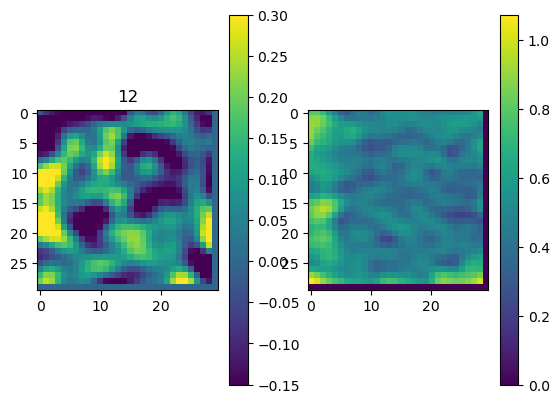

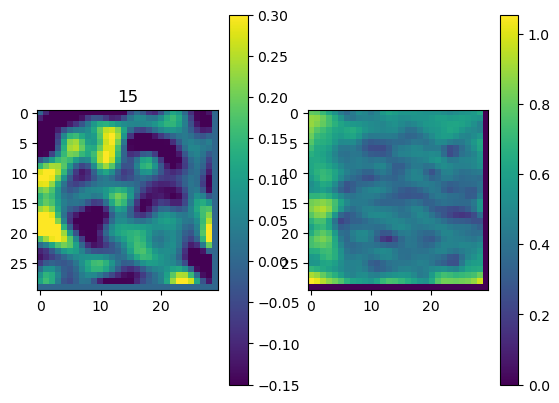

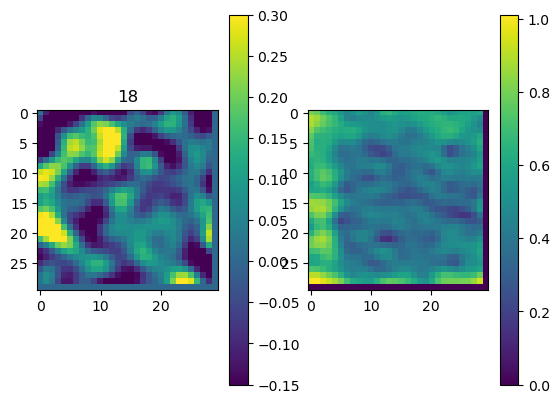

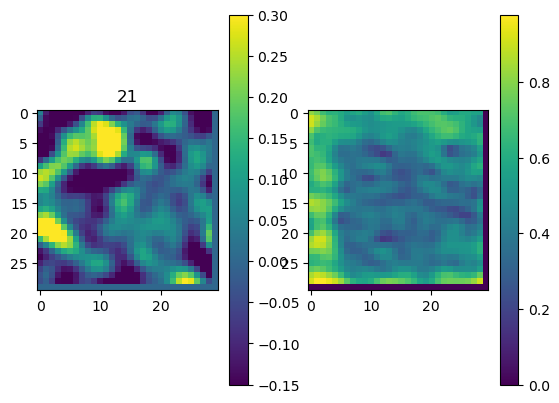

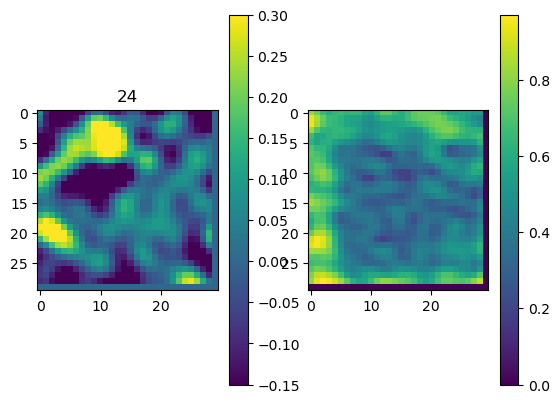

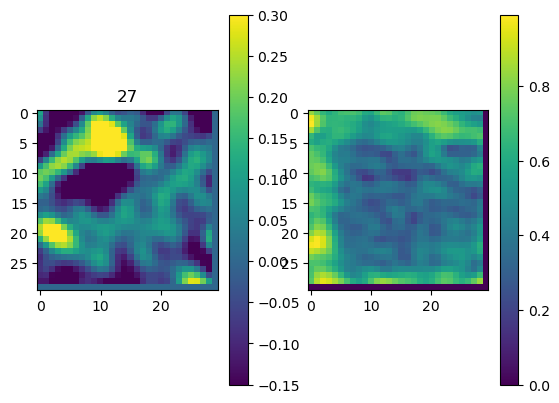

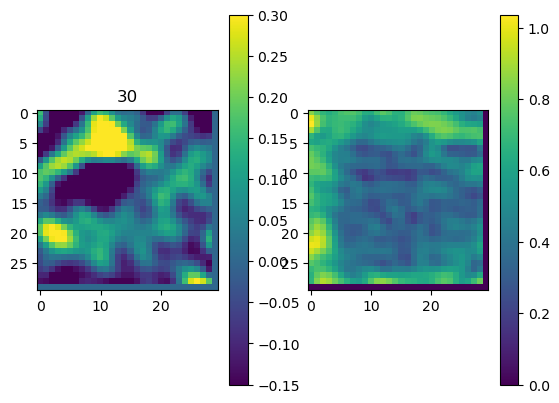

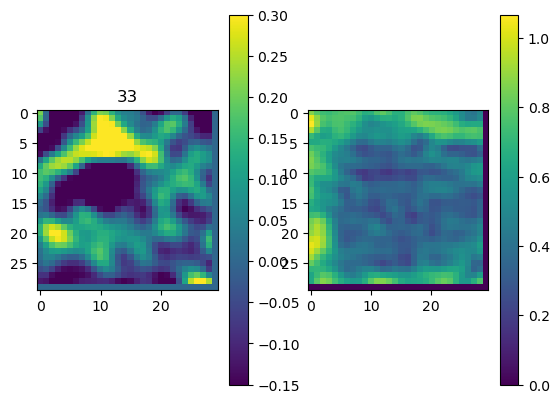

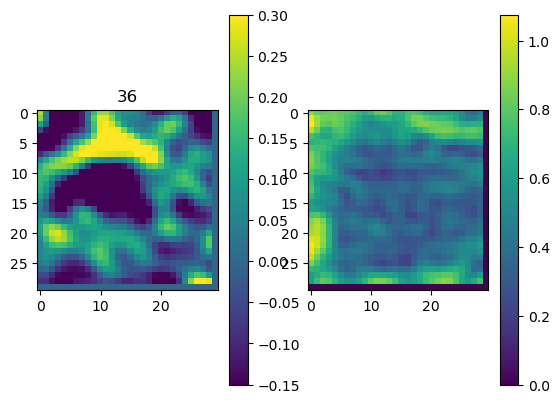

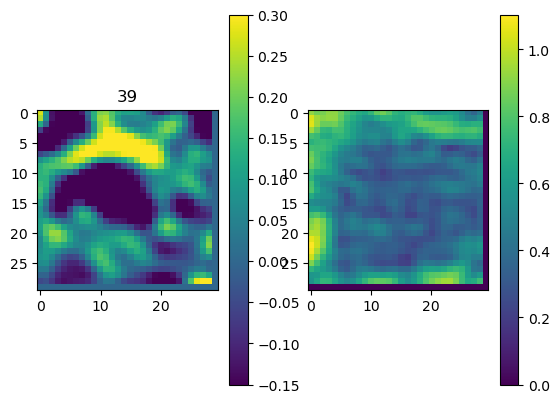

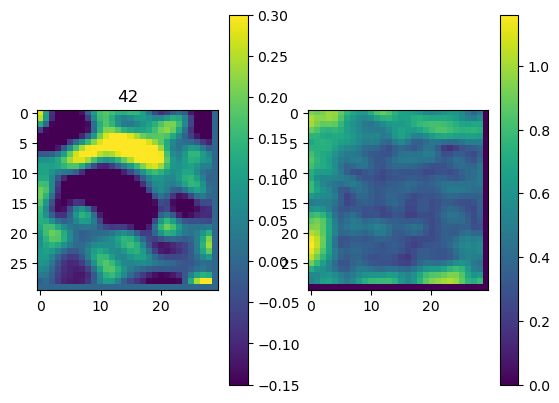

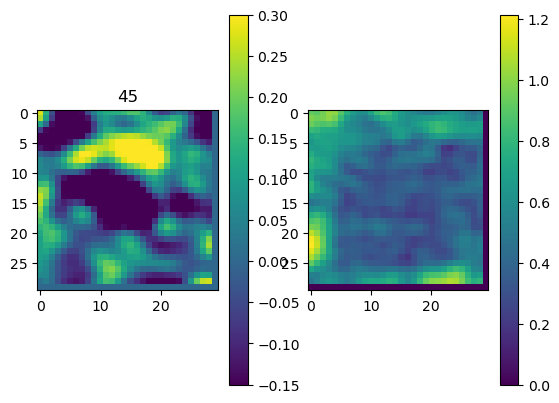

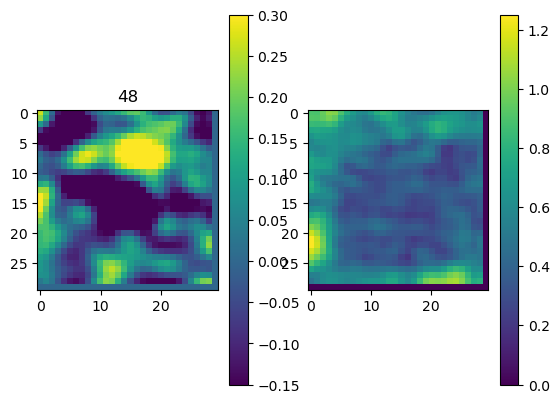

In [35]:
for t_index in range(0,50,3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(t_index)
    plt.imshow(sourcemean[t_index,:,:],clim=[-0.15,0.3])
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(np.sqrt(sourcevar[t_index,:,:]))#,clim=[-0.15,0.3])
    plt.colorbar()

# coding examples for generating particles

In [ ]:
exampleparticles = mInfer.genParticlesFromObservations(10)

In [ ]:
exampleparticles[:,0,2]

In [ ]:
plt.plot(exampleparticles[0,:,1],exampleparticles[0,:,2],'x')

In [ ]:
exampleparticles.shape #3430 points going in... each at a given time/space

In [ ]:
trickyparticles = np.random.rand(10,20,18,30,3)

In [ ]:
trickyparticles.shape

In [ ]:
mInfer.windmodel.getwind(trickyparticles).shape #3430 vectors out..

In [ ]:
mInfer.kernel.N_feat